In [1]:
library(glmnet)

# Feature selection and regularised regression


#Goal: give us an impression of what these methods can be used for, but
# also what limitations they have.


#WARNING: Both parts of assignment require some amount of repeated simulation/
# estimation of models which can take some time to run!

## ---- PART 1: Prediction quality vs feature selection ------------------------

# Lasso encodes variable selection through penalisation. 
#install.packages("tidyverse")
#install.packages("glmnet", repos = "https://cran.us.r-project.org")
library(tidyverse)
library(latex2exp)

# Simulating data: 

#' 
#' @param n Number of samples 
#' @param p Number of features
#' @param sparsity Percentage of zero elements in simulated regression coefficients
#' @param SNR Signal-to-noise ratio (see explanation above)
#' @param scaling.beta Scaling for the coefficient to make sure they are large
#' 
#' @return A list containing
#     {X}{n x p matrix of features}
#     {y}{n vector of responses}
#     {beta}{p vector of regression coefficients}

# Generate n observations from Gaussian, isometric dist (they are theoretically 
# uncorrelated)
# Rebeckas way of doing this is by creating a function that does this:

sim.data <- function(n, p, sparsity, SNR = 2, scaling.beta = 5){
  
  X <- matrix(rnorm(n*p), ncol = p) # nXp design matrix 
  
  non.zero.coeff <- ceiling((1-sparsity)*p) # Number of non-zero coeff
  
  # ceiling will take a numeric number (such as 1.1) and return the integer
  # closest and higher in value to this number (so 2 in my example)
  
  beta <- rep.int(0,p) #initialise 1Xp vector with 0
  
  beta[1:non.zero.coeff] <- scaling.beta * rnorm(non.zero.coeff) # Insert q scaled coeff from sd normal dist
  
  # (sd is beta_scale for the betas)
  
  
  # I think what we are doing here is basically creating some noise/
  # a sample
  # beta*X is the noise-less response
  # beta*X + sigma*epsilon is the actual response
  # sigma = sd_noise = sd_signal/SNR - we generate a reasonable noise sd
  
  # (So basically like we did with beta_scale above, we want to rescale
  # our random error so that we get reasonable results)
  sd.noise <- sqrt(sum((X %*% beta)^2)/(n-1))/SNR 
  
  
  y <- X%*%beta + sd.noise * rnorm(n) # Response 
  
  # We do not want the non-zero features in the first (1-sparsity)p 
  # number of columns only, so we reorder the columns:
  
  reord <- sample(p, p, replace = F)
  
  list(
    
    X = X[, reord],
    y = y,
    beta = beta[reord]
  )
  
}


Warning message:
"package 'glmnet' was built under R version 4.1.3"
Loading required package: Matrix

Loaded glmnet 4.1-4

Warning message:
"package 'tidyverse' was built under R version 4.1.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.3"
Warning message:
"package 'readr' was built under R version 4.1.3"
Warning message:
"package 'purrr' was built under R version 4.1.3"
Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'forcats' was built under R version 4.1.3"
-- Conflicts -----------------------

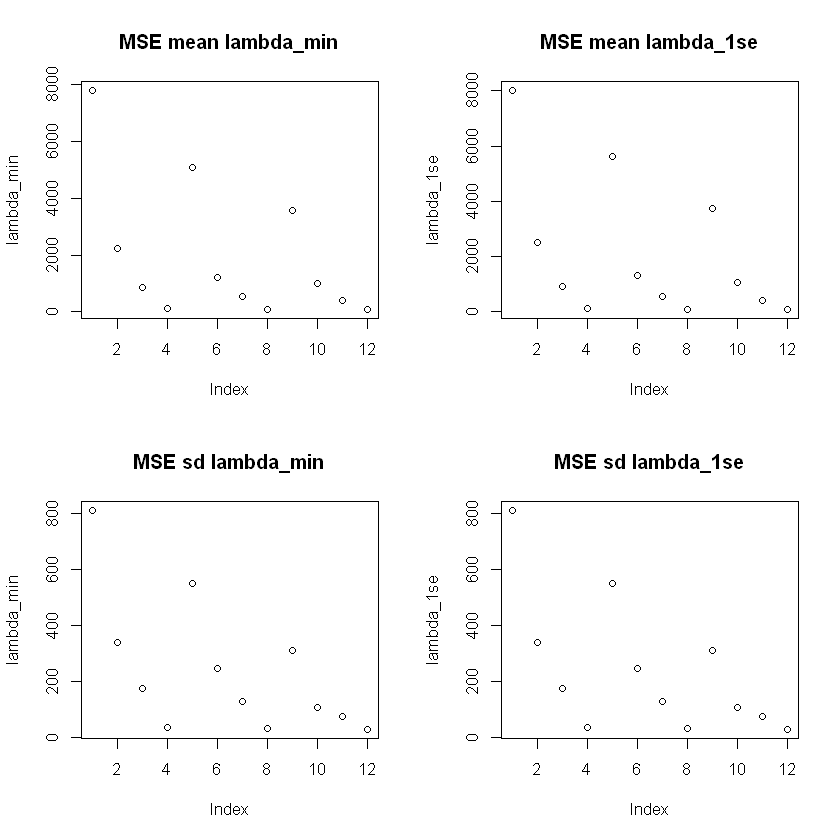

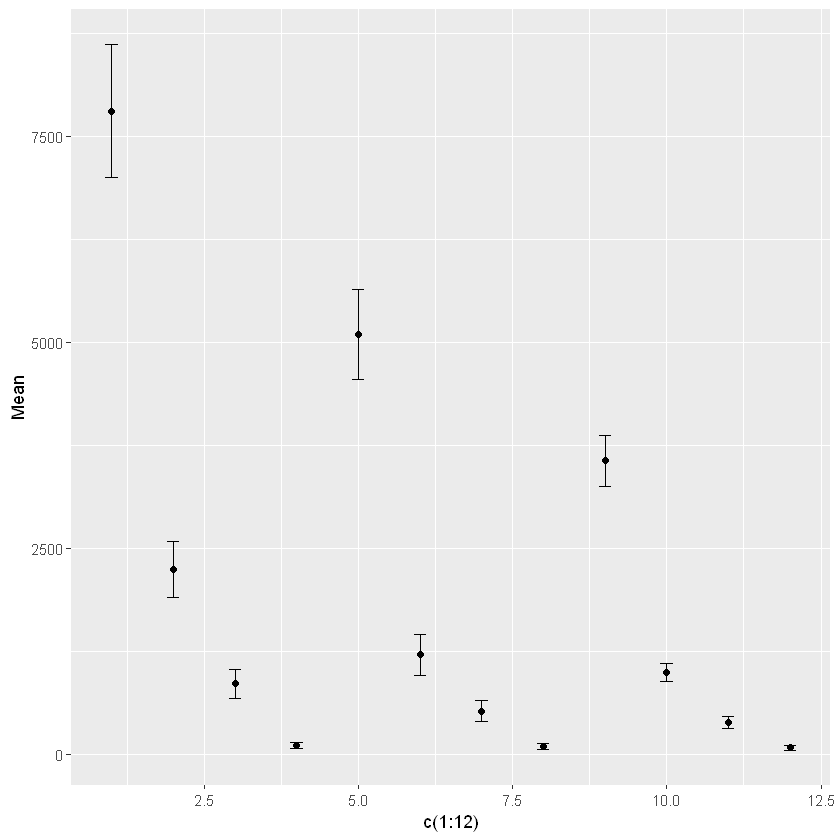

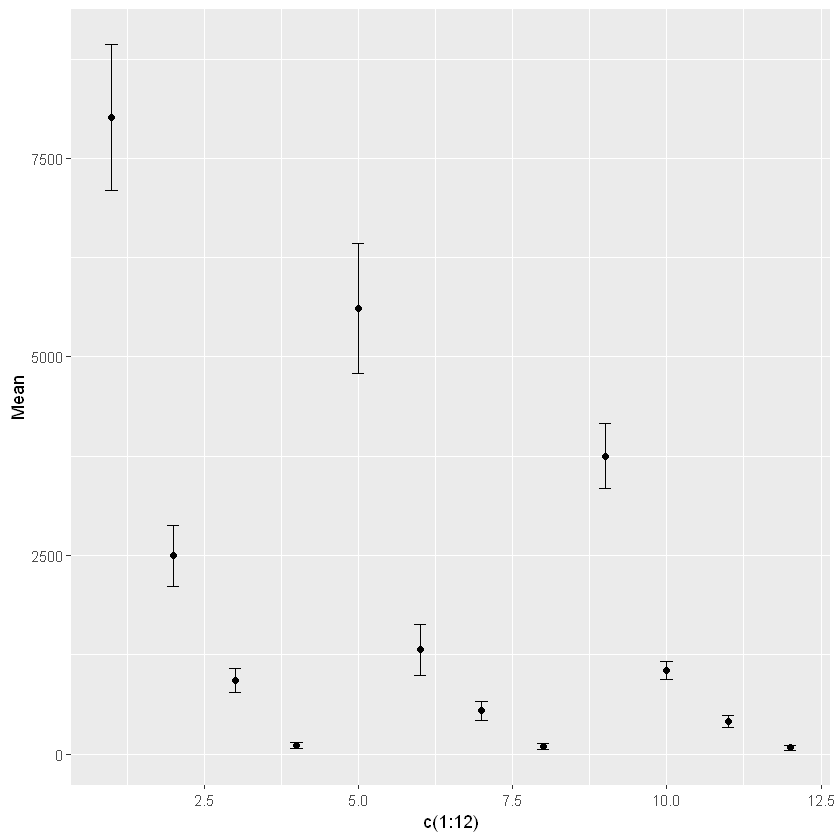

In [2]:
library(glmnet)

# Feature selection and regularised regression


#Goal: give us an impression of what these methods can be used for, but


# Test n - the data we test with (see Rebeckas notes about how to do cv)
n.test <- 500

# Number parameters
p = 1000


# Different ns to train with
number <- c(200,500,750)

# Different sparsity
sparse <- c(0.75,0.9, 0.95, 0.99)

return <- list()

# Number of repeated calculations for each combo of n and sparsity
loops <- 10

# Initiate vector for mse
mean.squared.error <- matrix(0, nrow =12, ncol = 2*loops)

# Initiate vector for beta_est
beta_est <- matrix(0,nrow = p+1, ncol = 2*loops*12)

# Something to note is that I don't think true beta contains intercept
# whilst beta_est (the estimated beta) does


# Initiate vector for collecting beta_true
beta_true <- matrix(0, nrow = p, ncol = 120)

# Loop over number of replications
for (l in 1:loops) {
  # Loop over number vector
  for (i in 1:3) {
    
    
   # Train your data on n.train observations
    n.train = number[i] 
      
   # Create data with n observations
    n = n.train + n.test
    
      # Loop over sparsity vector
    for (j in 1:4) {
      sparsity = sparse[j]
      
      return <- sim.data(n,p,sparsity)
      
      # 2. Determine hyperparameters
      
      suppressMessages(attach(return))
      
      
      
      
      
      # Define MSE function (from: https://stackoverflow.com/questions/39482436/why-calculating-mse-in-lasso-regression-gives-different-outputs)
      
      MSE <- function(x,y) { mean((x-y)^2)}
      
      # sample size
      cv.sample.size <- floor(n.train)
      
        # Index for randomly sampled training set (size n.train)
      train.ind <- sample(seq_len(n), size = cv.sample.size)
      
      # Training set
      
      train.X <- X[train.ind, ]
      
      train.y <- y[train.ind]
      
      # Test set
      
      test.X <- X[-train.ind, ]
      
      test.y <- y[-train.ind]
      
      # Fit linear model with lasso on training data
      probs.lasso <- cv.glmnet(train.X, train.y,
                               type.measure = "mse",
                               keep = T,
                               alpha =1
      )
      
      
      
      
      # Fetch the lambdas of relevance
      lasso.lambda.min <- probs.lasso$lambda.min
      lasso.lambda.1se <- probs.lasso$lambda.1se
      
     # Predict on test data with parameters of selected lambda
      pred.lasso.min <- predict(probs.lasso, s = lasso.lambda.min, newx = test.X)
      pred.lasso.1se <- predict(probs.lasso, s = lasso.lambda.1se, newx = test.X)
      
      # get MSE with training model and test data
      MSE.1 <- MSE(pred.lasso.min, test.y)
      MSE.2 <- MSE(pred.lasso.1se, test.y)
      
    # Use long if statement to collect into mean.squared.error
      if (i == 1 || i == 3) {
        
        mean.squared.error[i*i+j-1,l] <-  MSE.1
        mean.squared.error[i*i+j-1,l+10] <- MSE.2
        
        
        beta_true[,i*i+(j-1)+12*(l-1)] <- as.vector(return$beta)
        
        beta_est[,i*i+(j-1)+12*(l-1)] <- as.vector(coef(probs.lasso, s = "lambda.min"))
        
        beta_est[,i*i+(j-1)+12*(l-1)+120] <- as.vector(coef(probs.lasso, s = "lambda.1se"))
        
      } else if (i == 2) {
        
        mean.squared.error[i*i+j,l] <-  MSE.1
        mean.squared.error[i*i+j,l+10] <- MSE.2
        
        beta_true[,i*i+(j)+12*(l-1)] <- as.vector(return$beta)
        
        
        beta_est[,i*i+(j)+12*(l-1)] <- as.vector(coef(probs.lasso, s = "lambda.min"))
        
        beta_est[,i*i+(j)+12*(l-1)+120] <- as.vector(coef(probs.lasso, s = "lambda.1se"))
        
      }
      
    }
    
  }
  
}



# Compute mean for each row (the first 10 col are lambda_min)
# the last 10 col are lambda_1se
mean.lambda.min <- apply(mean.squared.error[,c(1:10)], 1, mean)

mean.lambda.1se <- apply(mean.squared.error[,c(11:20)], 1, mean)


# Compute respective sd
sd.lambda.min <- apply(mean.squared.error[,c(1:10)], 1, sd)

sd.lambda.1se <- apply(mean.squared.error[,c(11:20)], 1, sd)

# Plot mean and sd for lambda_min and lambda_1se

par(mfrow = c(2,2))

plot(mean.lambda.min,
     ylab = "lambda_min",
     main = "MSE mean lambda_min")
plot(mean.lambda.1se,
     ylab = "lambda_1se",
     main = "MSE mean lambda_1se")

plot(sd.lambda.min,
     ylab = "lambda_min",
     main = "MSE sd lambda_min")
plot(sd.lambda.min,
     ylab = "lambda_1se",
     main = "MSE sd lambda_1se")




# Plot with mean and sd as bars instead:

# Load ggplot2
library(ggplot2)

df_min<-data.frame(Mean=mean.lambda.min,
                   sd=sd.lambda.min)

ggplot(df_min, aes(x = c(1:12), y=Mean)) + geom_point() +
  geom_errorbar(aes(ymin=Mean-sd, ymax=Mean+sd), width=.2)


df_1se<-data.frame(Mean=mean.lambda.1se,
                   sd=sd.lambda.1se)

ggplot(df_1se, aes(x = c(1:12), y=Mean)) + geom_point() +
  geom_errorbar(aes(ymin=Mean-sd, ymax=Mean+sd), width=.2)



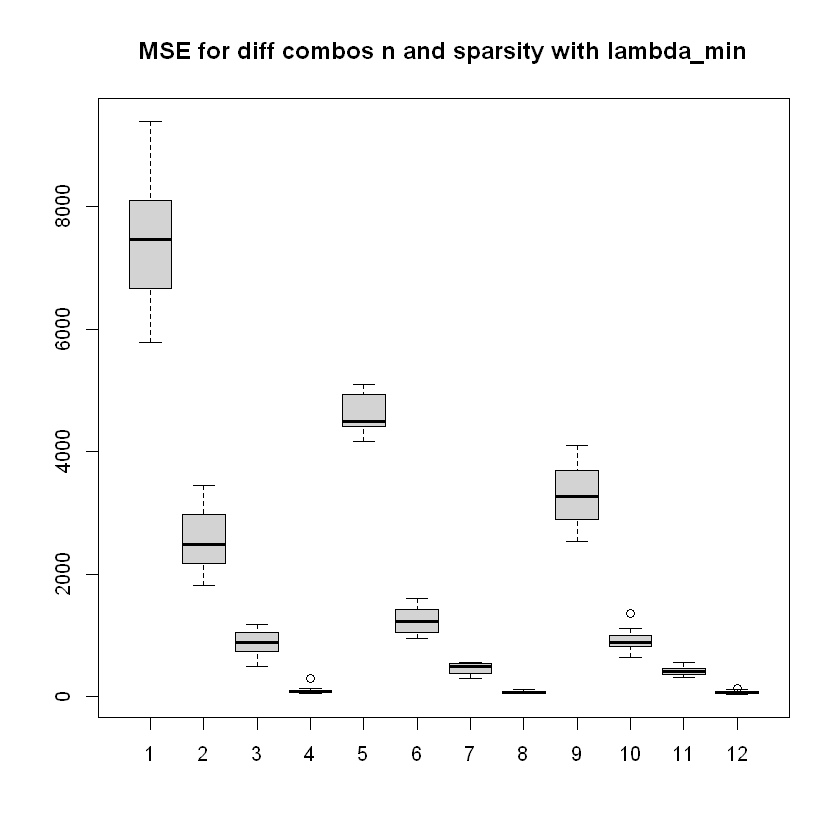

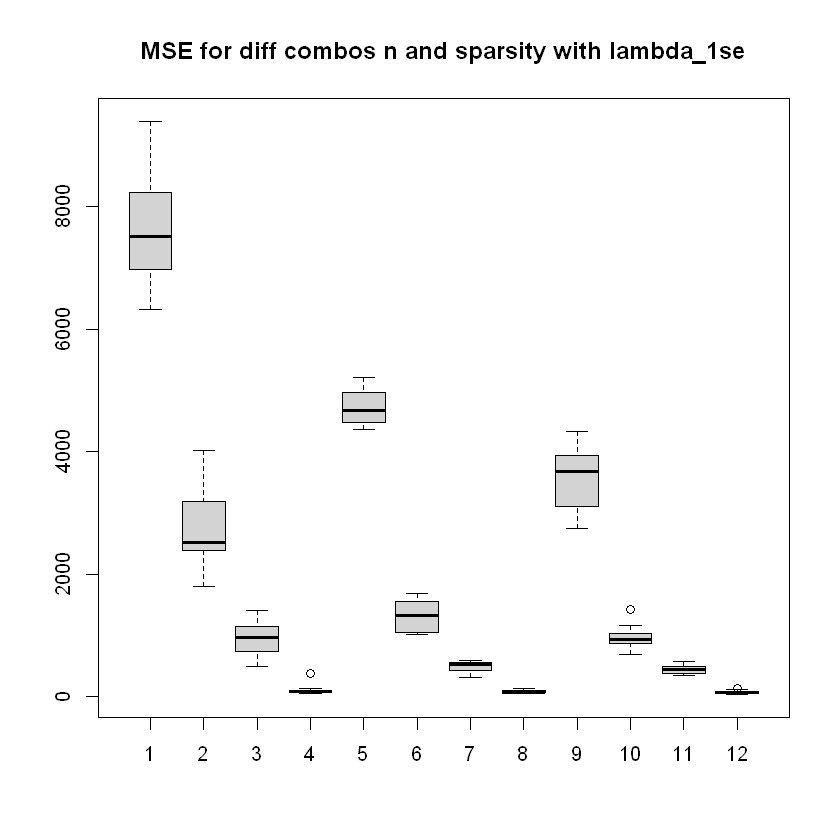

In [9]:
# Boxplots for easier visualisation

boxplot(t(mean.squared.error[,c(1:10)]), main = "MSE for different combos of n and sparsity, lambda_min")
boxplot(t(mean.squared.error[,c(11:20)]), main = "MSE for different combos of n and sparsity, lambda_1se")

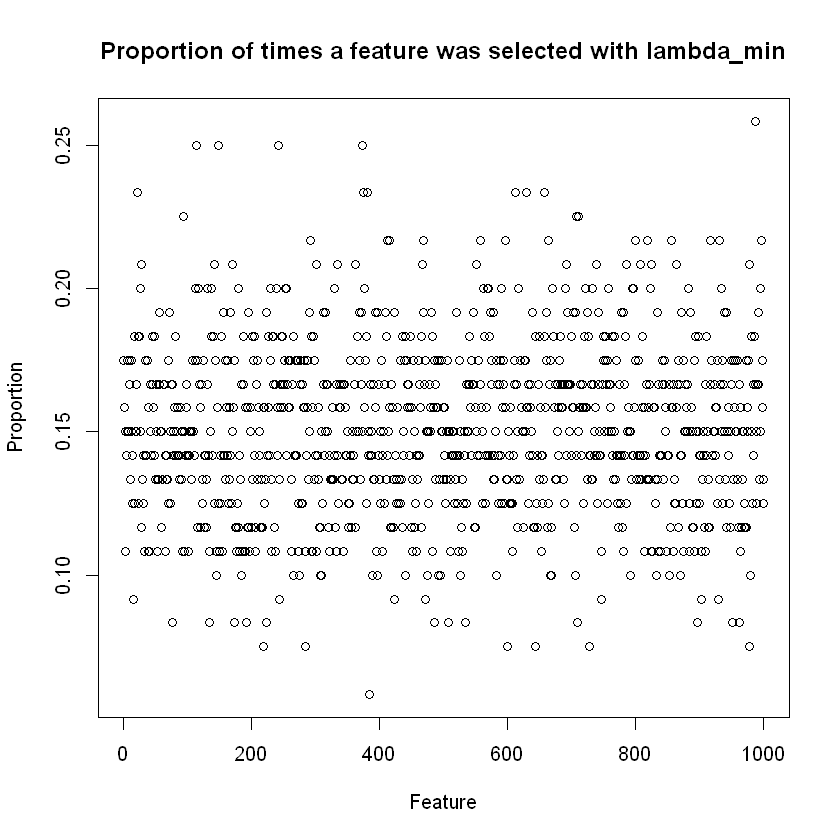

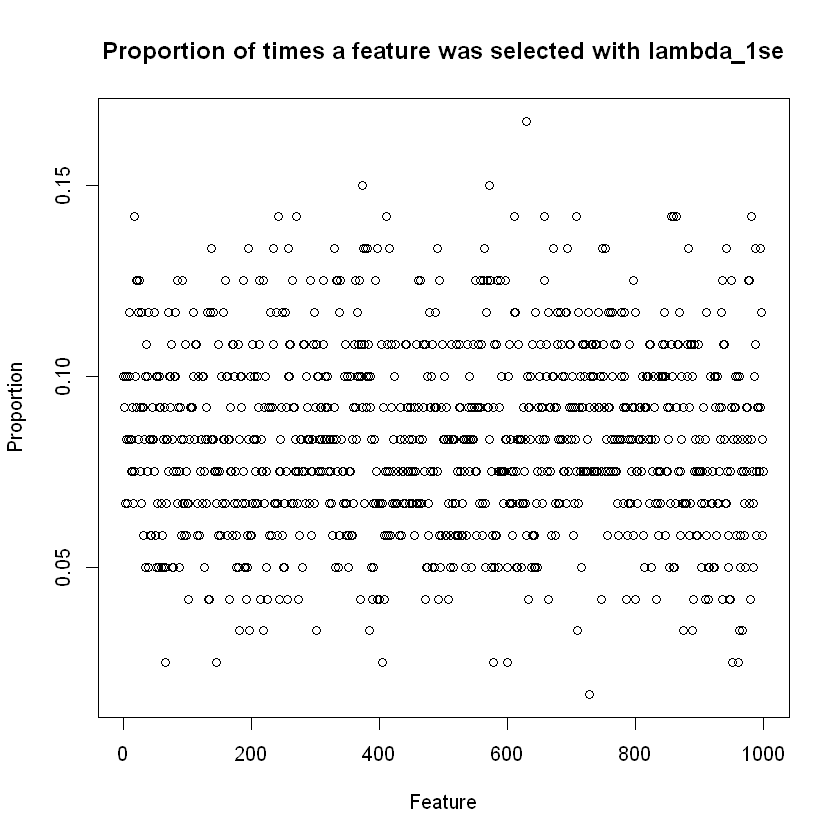

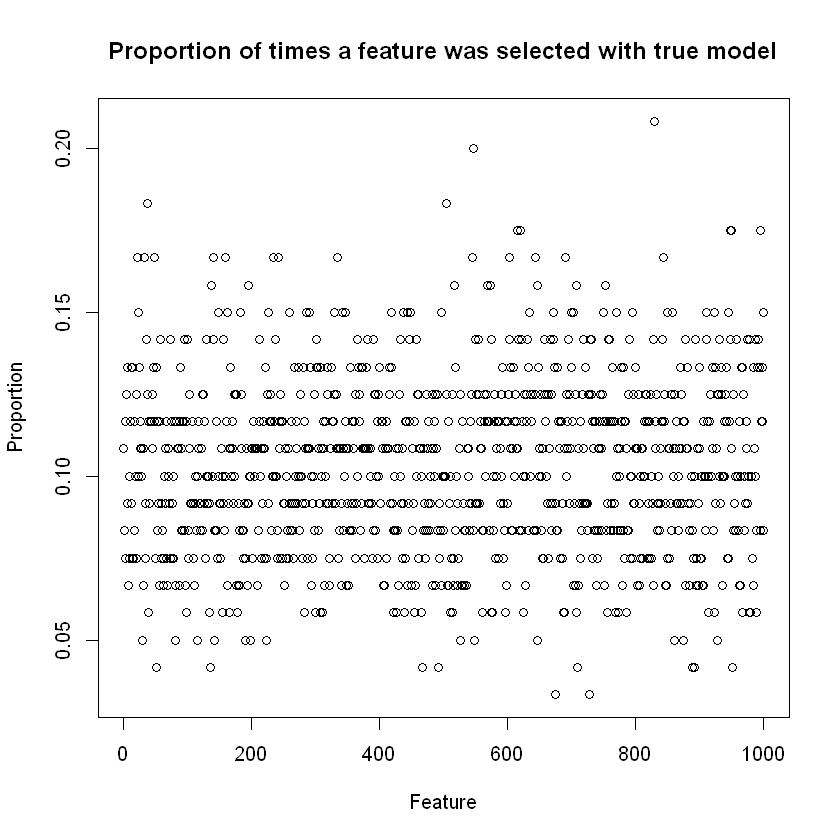

In [17]:

## ---- Feature selection ------------------------------------------------------


# Make your coeff matrices binary (probably better way to do this but I did a function)


 make.01 <- function(v, param, loop){
   
     # v is your coef matrix
     # param = p
     # loop = number repetitions
     
     
   x_01 <- matrix(2, nrow = param+1, ncol = 2*loop*12)
   
     # All non-zero values become 1
   for (i in 1:(param+1)) {
     for (j in 1:(2*loop*12)) {
       
       if (round(v[i,j],2) != 0) # < 0 || beta_est[i,j] > 0){
       {
         x_01[i,j]  <- 1
         
       } else if (round(v[i,j],2) == 0){
         x_01[i,j]  <- 0
       }
     }
   }
 return <- x_01
}

# Make your estimators binary with above function
beta_01_est <- make.01(beta_est, p, loops)

beta_01_true <- make.01(beta_true, p-1, loops/2)

# Proportion of times for each repetition that a feature was selected
prop.1.est.min <- apply(beta_01_est[-1,c(1:120)], 1, mean)
prop.1.est.1se <- apply(beta_01_est[-1,c(121:240)], 1, mean)
#NOTE: 

# Strangely enough differs for true model too... but prob because of random sampling
prop.1.true <- apply(beta_01_true, 1, mean)


#par(mfrow = c(1,2))

plot(prop.1.est.min,
    main = "Proportion of times a feature was selected with lambda_min",
    xlab = "Feature",
    ylab = "Proportion")

plot(prop.1.est.1se,
    main = "Proportion of times a feature was selected with lambda_1se",
    xlab = "Feature",
    ylab = "Proportion")

plot(prop.1.true,
    main = "Proportion of times a feature was selected with true model",
    xlab = "Feature",
    ylab = "Proportion")

# seems like there are barely any features being selected 1/5 of times...
# probably something is not correct



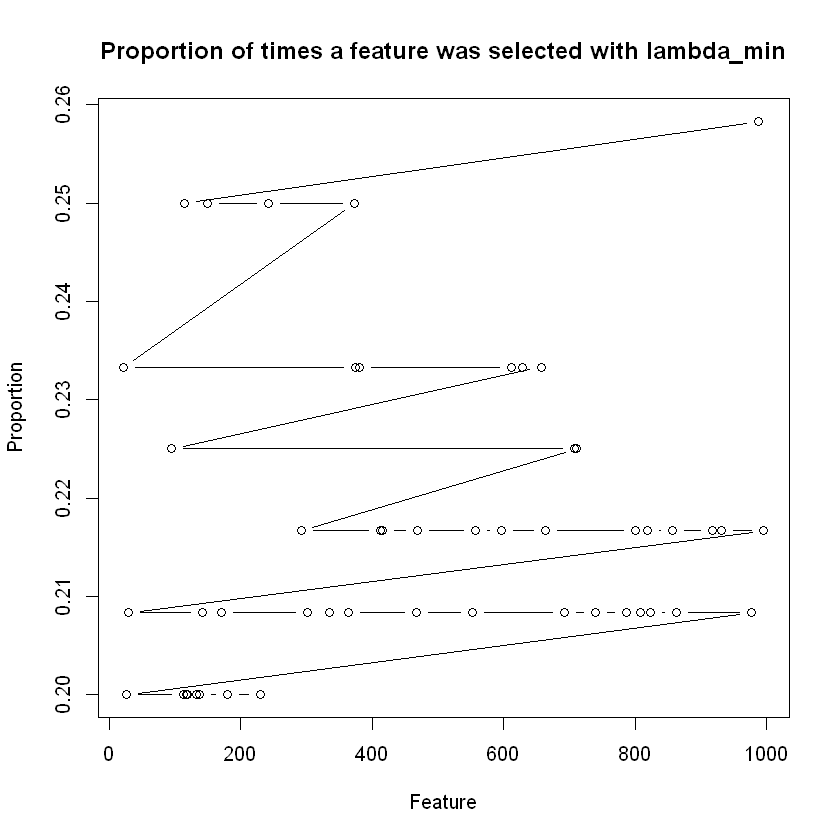

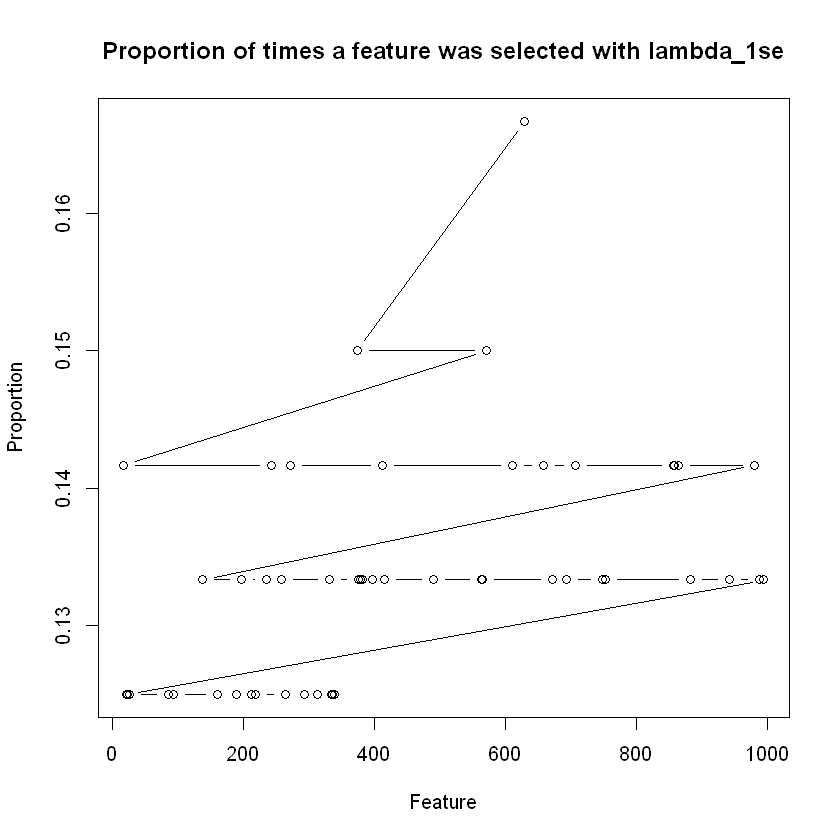

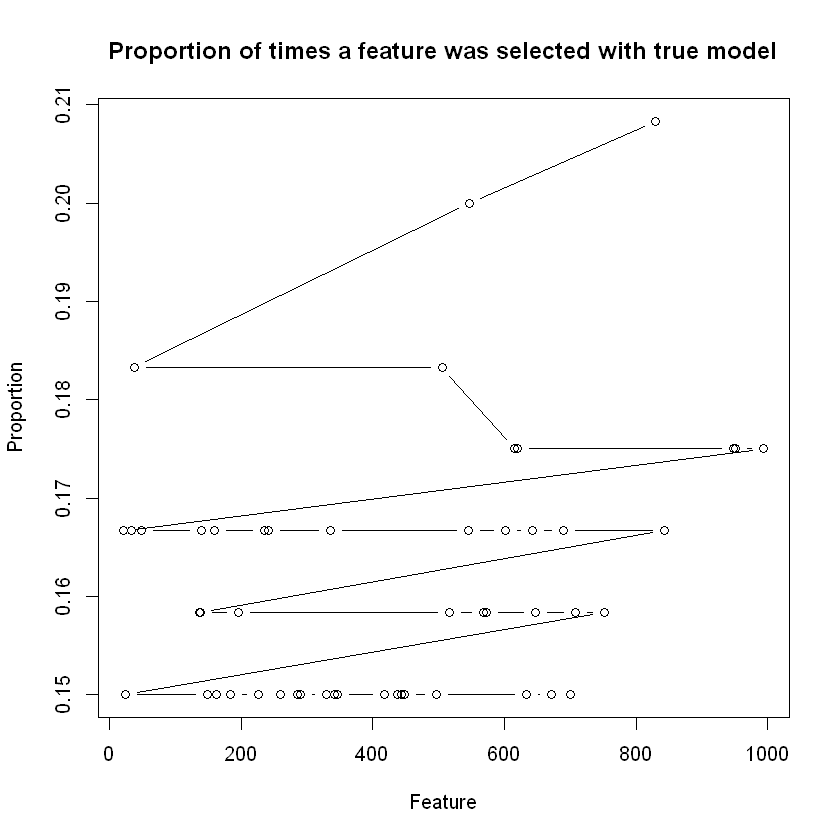

In [29]:
feat <- c(1:1000)

new.min <- as.data.frame(cbind(feat,prop.1.est.min))
new.1se <- as.data.frame(cbind(feat,prop.1.est.1se))
new.true <- as.data.frame(cbind(feat,prop.1.true))

sorted.min <- new.min[order(new.min$prop.1.est.min, decreasing = T),]
sorted.1se <- new.1se[order(new.1se$prop.1.est.1se, decreasing = T),]
sorted.true <- new.true[order(new.true$prop.1.true, decreasing = T),]

high.min <- sorted.min[c(1:50),]
high.1se <- sorted.1se[c(1:50),]
high.true <- sorted.true[c(1:50),]

plot(high.min,
     main = "Proportion of times a feature was selected with lambda_min",
     xlab = "Feature",
     ylab = "Proportion",
    type = "b")

plot(high.1se,
     main = "Proportion of times a feature was selected with lambda_1se",
     xlab = "Feature",
     ylab = "Proportion",
    type = "b")

plot(high.true,
     main = "Proportion of times a feature was selected with true model",
     xlab = "Feature",
     ylab = "Proportion",
    type = "b")


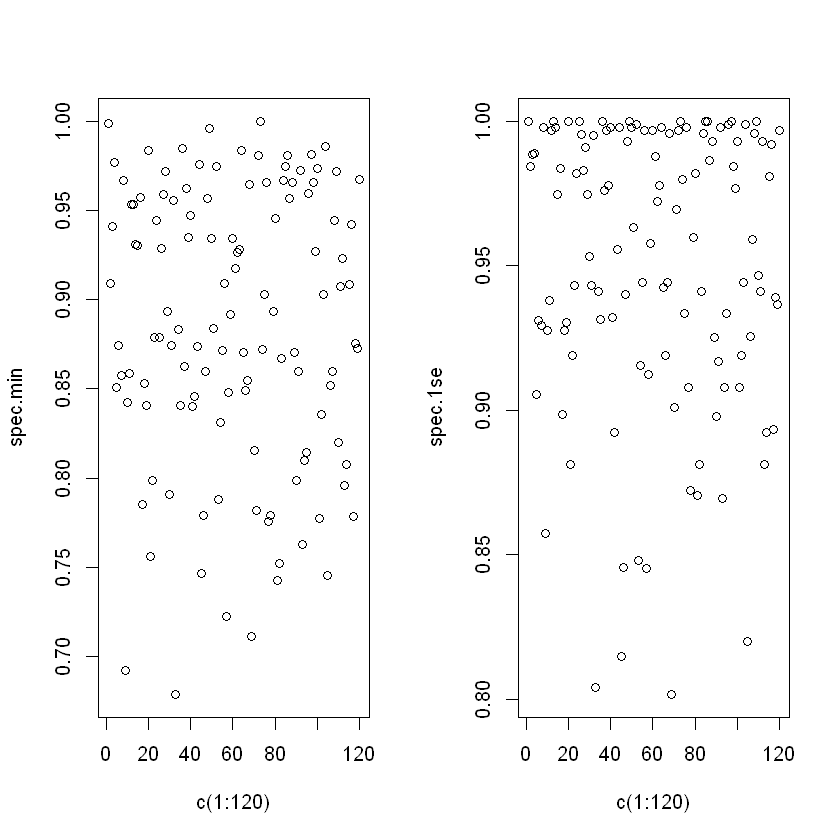

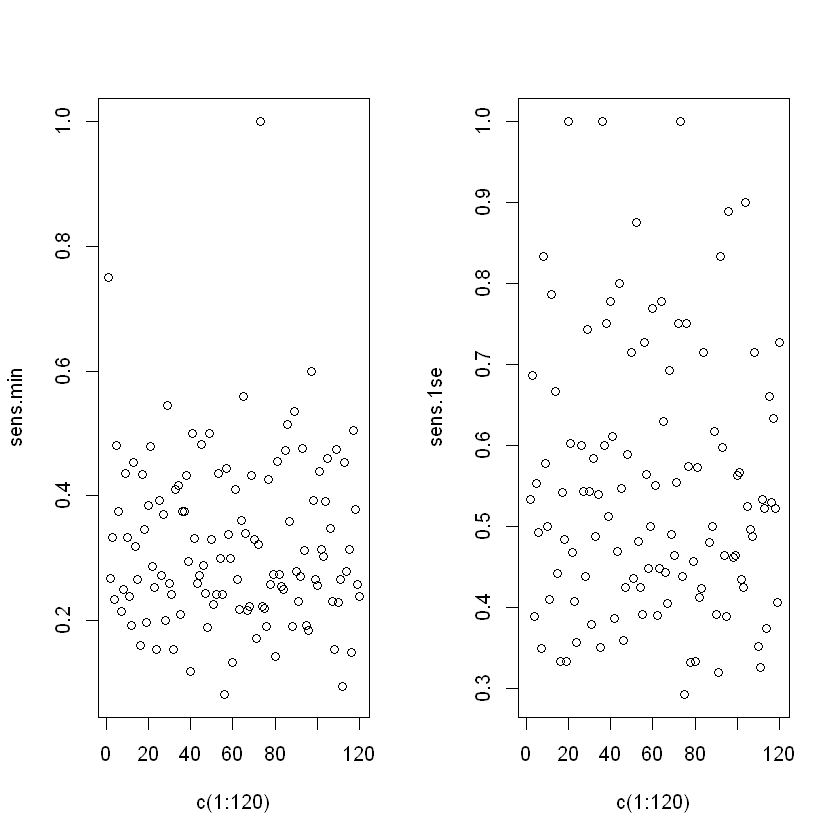

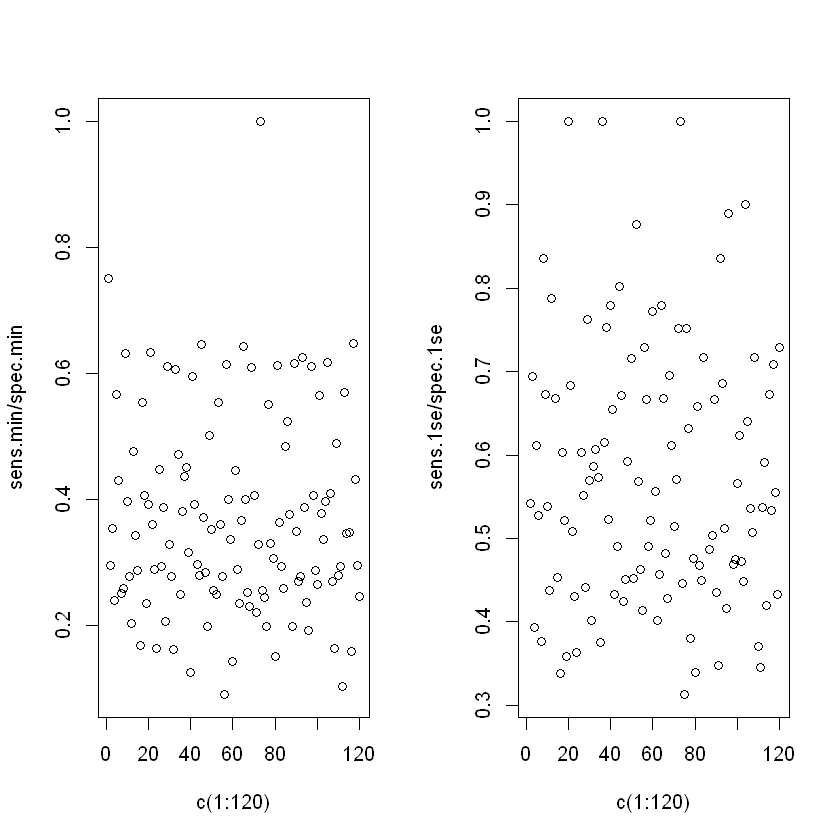

In [5]:
#combos <- 12


# Make your coef matrices binary
# I made weird functin to do this
 make.01 <- function(v, param, loop){
   
   # v is your beta matrix
   # param = number param
   # loop = loops (number repetitions)
   
   
   
   x_01 <- matrix(2, nrow = param+1, ncol = 2*loop*12)
   
   for (i in 1:(param+1)) {
     for (j in 1:(2*loop*12)) {
       
       if (round(v[i,j],2) != 0) # < 0 || beta_est[i,j] > 0){
       {
         x_01[i,j]  <- 1
         
       } else if (round(v[i,j],2) == 0){
         x_01[i,j]  <- 0
       }
     }
   }
 return <- x_01
}

beta_01_est <- make.01(beta_est, p, loops )

beta_01_est_non.int <- beta_01_est[-1,]

beta_01_true <- make.01(beta_true, p-1, loops/2)



# Calculating specificity: 

specificity <- function(v,u){
  
  # Zero entries in u
  zero.entries.true <- u == 0
  
  # Remove all non-zero entries in u
  u <- u[zero.entries.true]
  
  # Remove entries in v which are non-zero in u
  v <- v[zero.entries.true]
  
  # Zero entries in v
  zero.in.est <- v == 0
  
  # Remove all non-zero entries in what is left of v
  v <- v[zero.in.est]
  
  # How many entries which are 0 in u are also zero in v? = specificity
  spec <- length(v)/length(u)
  
  return <- spec
  
}

# Initiate specificity matrices for storing specificity
spec.min <- matrix(0, nrow = 1, ncol = 120)
spec.1se <- matrix(0, nrow = 1, ncol = 120)

# Loop over each repeated combos to get specificity
for (i in 1:120) {

spec.min[i] <- specificity(beta_01_est_non.int[,i], beta_01_true[,i])

spec.1se[i] <- specificity(beta_01_est_non.int[,i+120], beta_01_true[,i])
  
}

# Plot results
par(mfrow = c(1,2))
# 
plot(c(1:120),spec.min)
# 
plot(c(1:120),spec.1se)

# Calculating sensitivity: 

sensitivity <- function(v,u){
  
  # Zero entries in u
  non.zero.entries.est <- v == 1
  
  # Remove all zero entries in v
  v <- v[non.zero.entries.est]
  
  # Remove entries in u which are zero in v
  u <- u[non.zero.entries.est]
  
  # non-zero entries in u
  non.zero.in.true <- u == 1
  
  # Remove all zero entries in what is left of u
  u <- u[non.zero.in.true]
  
  # How many entries which are 1 in v (est) are also 1 in u(true)? = sensitivity
  sens <- length(u)/length(v)
  
  return <- sens
  
}

# Initiate specificity matrices for storing sensitivity
sens.min <- matrix(0, nrow = 1, ncol = 120)
sens.1se <- matrix(0, nrow = 1, ncol = 120)

# Loop over each repeated combos to get sensitivity
for (i in 1:120) {
  
  
  sens.min[i] <- sensitivity(beta_01_est_non.int[,i], beta_01_true[,i])
  
  sens.1se[i] <- sensitivity(beta_01_est_non.int[,i+120], beta_01_true[,i])
  
}

# Plot results
par(mfrow = c(1,2))
# 
plot(c(1:120),sens.min)
# 
plot(c(1:120),sens.1se)

plot(c(1:120),sens.min/spec.min)
plot(c(1:120),sens.1se/spec.1se)


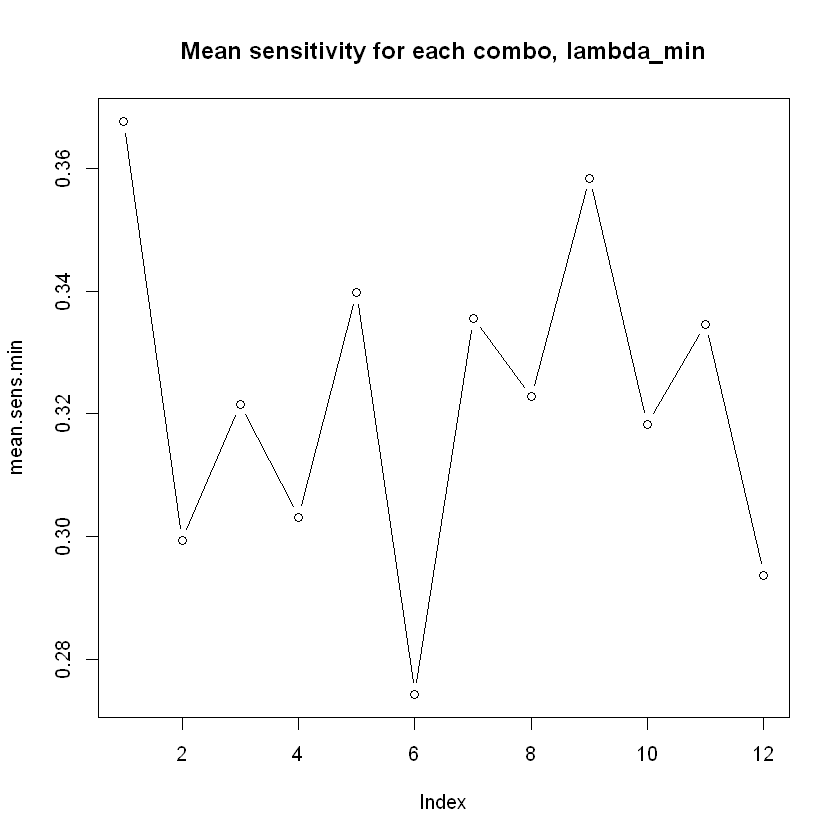

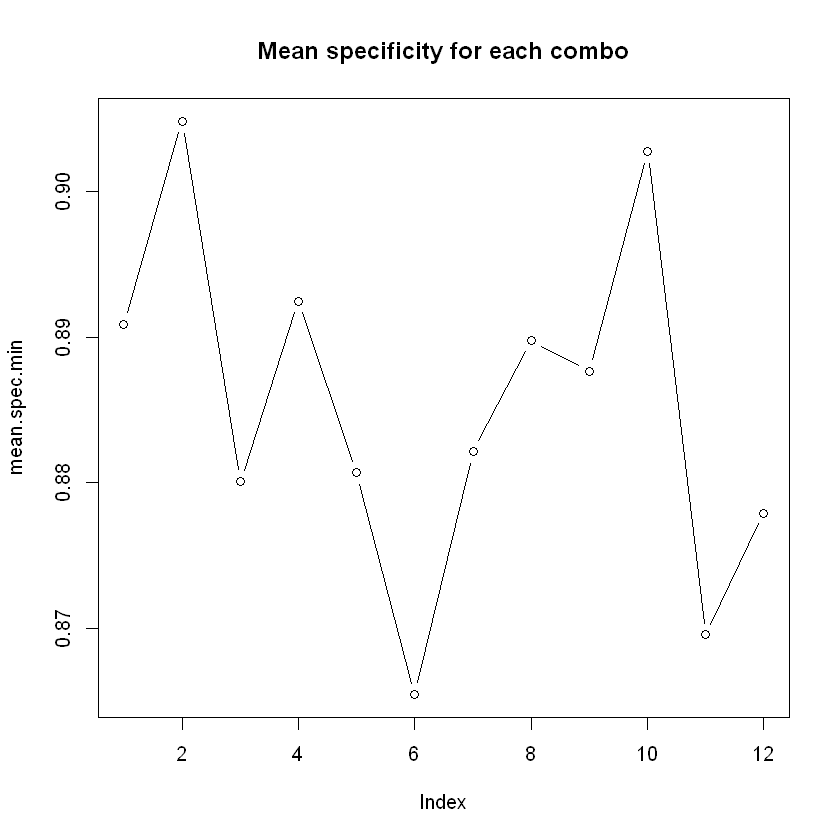

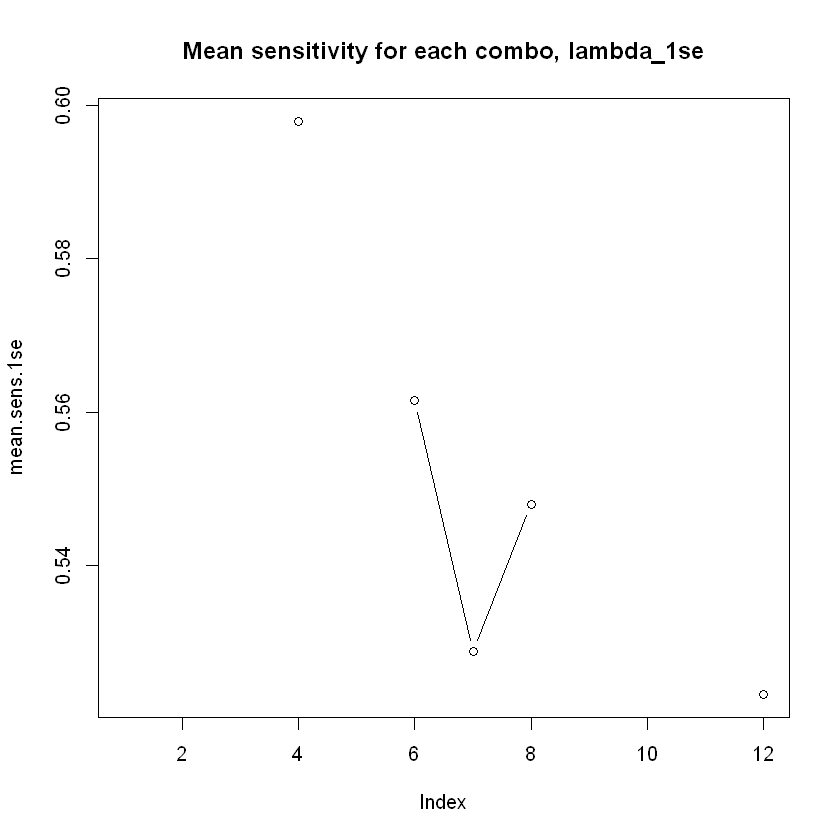

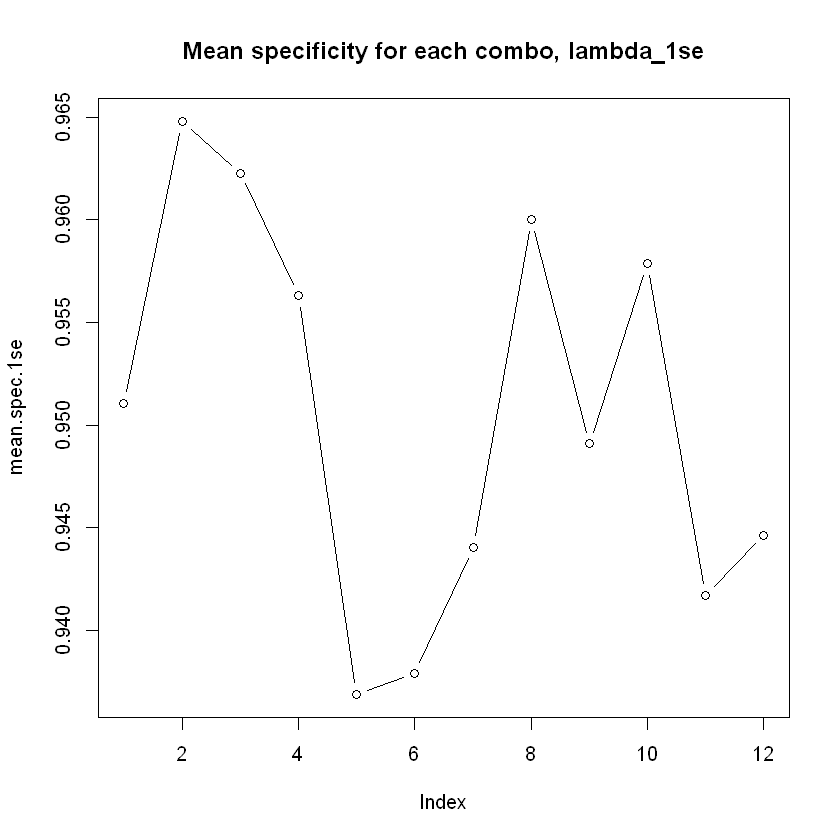

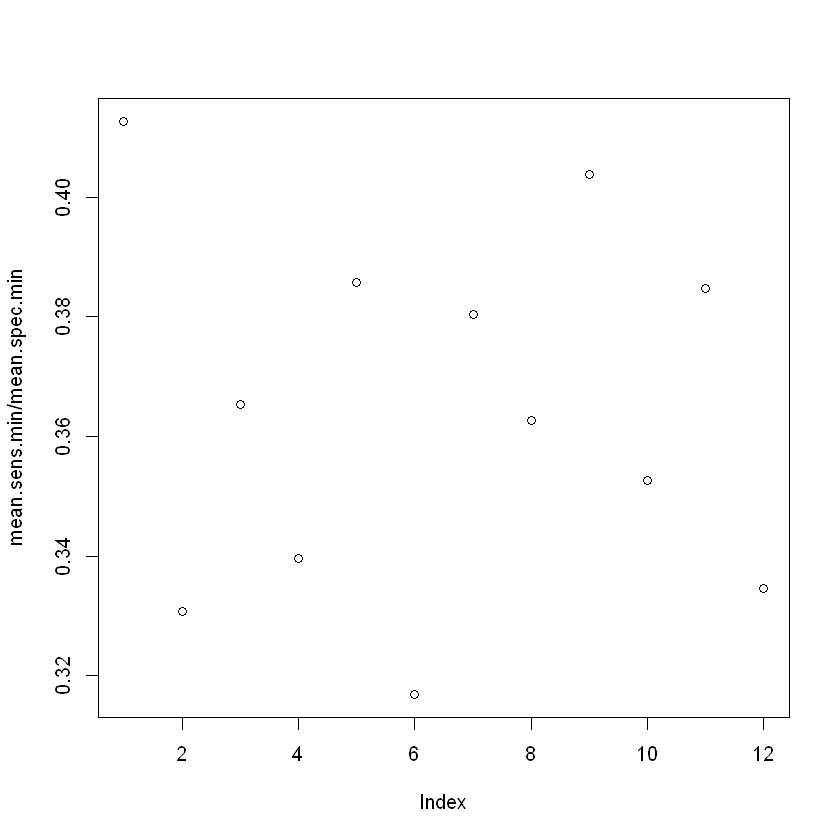

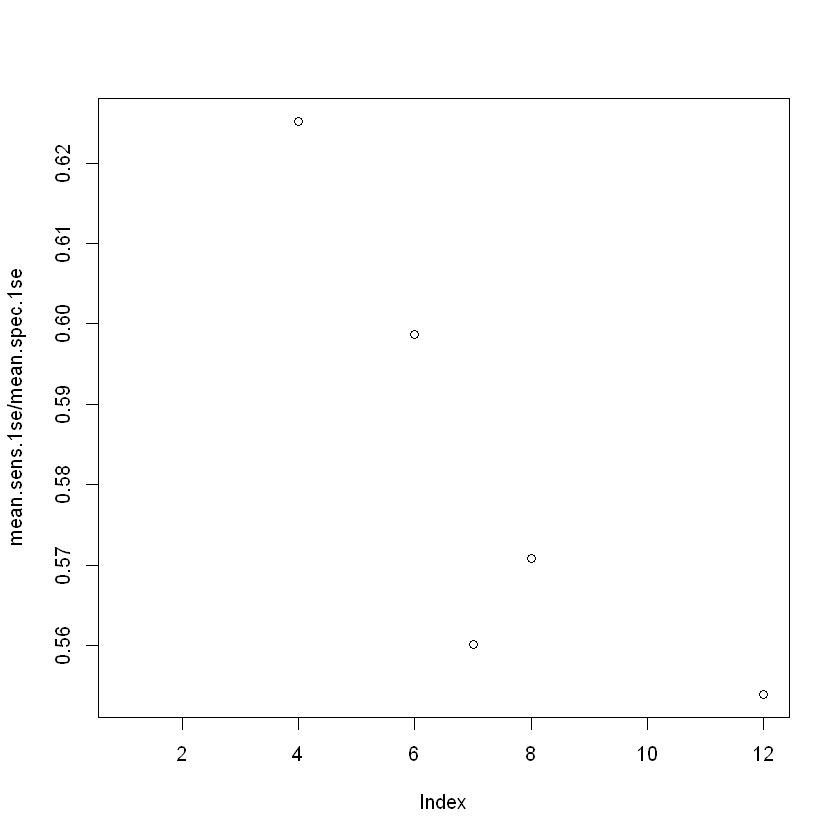

In [7]:

mean.sens.min <- matrix(0,nrow = 12, ncol = 1)
mean.spec.min <- matrix(0,nrow = 12, ncol = 1)
mean.sens.1se <- matrix(0,nrow = 12, ncol = 1)
mean.spec.1se <- matrix(0,nrow = 12, ncol = 1)

for (i in 1:12){
  
  mean.sens.min[i,] <- apply(t(sens.min[1,c((1+10*(i-1)):(10*i))]), 1, mean)
  mean.spec.min[i,] <- apply(t(spec.min[1,c((1+10*(i-1)):(10*i))]), 1, mean)
  mean.sens.1se[i,] <- apply(t(sens.1se[1,c((1+10*(i-1)):(10*i))]), 1, mean)
  mean.spec.1se[i,] <- apply(t(spec.1se[1,c((1+10*(i-1)):(10*i))]), 1, mean)

  
}

#par(mfrow = c(2,2))

plot(mean.sens.min, type = "b", main  = "Mean sensitivity for each combo, lambda_min" )
plot(mean.spec.min, type = "b", main  = "Mean specificity for each combo" )
plot(mean.sens.1se, type = "b", main  = "Mean sensitivity for each combo, lambda_1se")
plot(mean.spec.1se, type = "b", main  = "Mean specificity for each combo, lambda_1se")

plot(mean.sens.min/mean.spec.min)

plot(mean.sens.1se/mean.spec.1se)


